# Lecture 5 - Image Segmentation

In this notebook, we will discuss how we will segment objects of interest in our image. Specifically, we will discuss:
1. Thresholding and Otsu's Method
1. Color Image Segmentation
1. Chromaticity Segmentation

The contents of this notebook is compiled from the following references:

- C Alis,*"Introduction to Digital Image"*, IIP 2018

Organized by:
Benjur Emmanuel L. Borja

---

There will be cases when you need to isolate certain objects in an image for processing and analysis.  And more often than not these areas of interest are not conveniently isolated against an obvious background.  Fruit in a grocery cart, cars on the road, people on a court--there are so many ways that these could appear in photos that isolating any particular one is not so straightforward as 'picking-a-colour-and-go'.
Consider the following image:

![image](orange_bag.png)

This is an example of the simple case where we have a conveniently white background.

## 1. Thresholding
Our first method to segment the image is to perform a simple thresholding method. However, we would need to determine the propoer threshold to use to seperate our image.
### 1.1 Trial and Error
The first method is to simply use **Trial and Error** to find this value. Trying it our in our image:

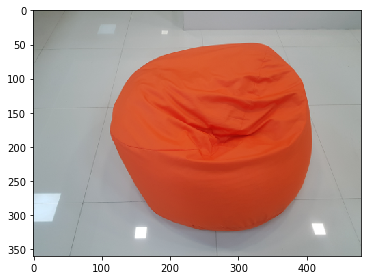

In [2]:
from skimage.io import imread, imshow
orange_bag = imread('orange_bag.png')
imshow(orange_bag)

As we have done before, we will convert the image into grayscale to apply our desired threshold.  From the threshold alone, we see that trial-and-error is a process that needs extensive fine-tuning with a human agent to find the best parameters as each subject will interface with the background in their own way.  Another illustration of this is: Have you ever tried to use a background during a video call, but the software ends up cutting you out together with the background?  It is a similar problem---that they tried to generalize some parameters for how the subject appears against the background.

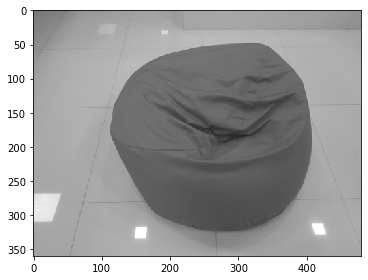

In [3]:
from skimage.color import rgb2gray
orange_bag_gray = rgb2gray(orange_bag)
imshow(orange_bag_gray)

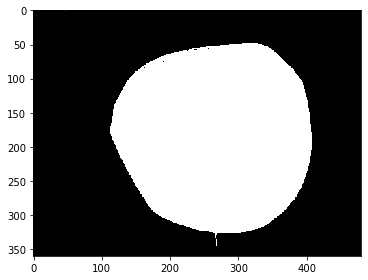

In [29]:
th = 0.46
orange_bag_bw = orange_bag_gray<th
imshow(orange_bag_bw)

#### Exercise:
Use morphological operations and regionsprops to find the area of the beanbag (in pixels).

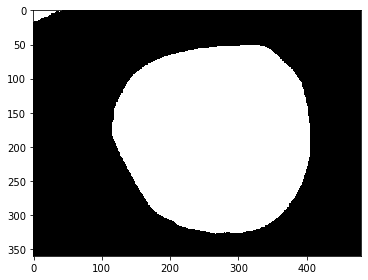

In [12]:
from skimage.morphology import erosion, dilation

imshow(erosion(orange_bag_bw))

bag area in pixels:  64070


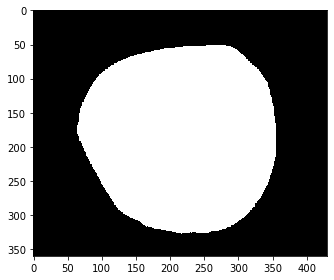

In [25]:
import numpy as np

orange_bag_bw2 = erosion(erosion(orange_bag_bw))
print('bag area in pixels: ', len(np.where(orange_bag_bw2==True)[0]))
imshow(orange_bag_bw2)

### 1.2 Otsu's Method
Here we discuss the Otsu's method of automatically finding the threshold value. Otsu's method assumes that your image is composed of a background and a foreground. This method works by minimizing the intra-class variance or maximizing the inter-class variance. Let's try it out:

First we get the histogram of our image:

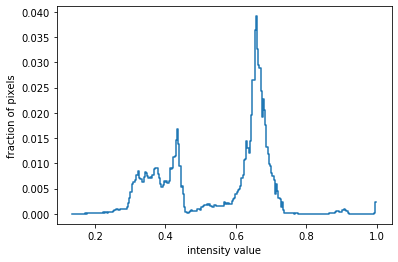

In [5]:
from skimage.exposure import histogram, cumulative_distribution
import matplotlib.pyplot as plt
import numpy as np

freq, bins = histogram(orange_bag_gray)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('intensity value')
plt.ylabel('fraction of pixels');

Then we initialize our variables for the Otsu's Method.

In [6]:
total = sum(freq)
sumB = 0 # Sum of Background
wB = 0 # Weight of Background
maximum = 0

sum1 = sum(np.arange(0,256) * freq) #Total Sum

In [7]:
levels = []
for i in np.arange(len(bins)):
    wB = wB + freq[i]
    wF = total - wB # Weight of Foreground
    if wB == 0 or wF == 0:
        break
    sumB = sumB + (i-1)*freq[i]
    mF = (sum1 - sumB) / wF # Mean of Foreground
    mB = sumB / wB # Mean of Background
    between = wB * wF * (mB - mF) * (mB - mF)
    levels.append(between)
    if between >= maximum:
        level = i
        maximum = between

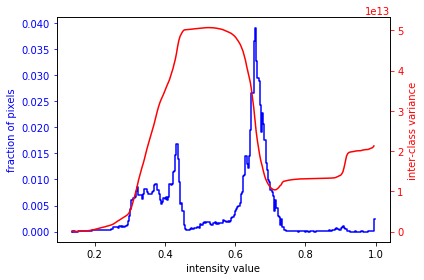

In [8]:
fig, ax1 = plt.subplots()
ax1.step(bins, freq*1.0/freq.sum(),'b')
ax1.set_xlabel('intensity value')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('fraction of pixels', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(bins[0:255],levels,'r')
ax2.set_ylabel('inter-class variance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

Applying our computed threshold level:

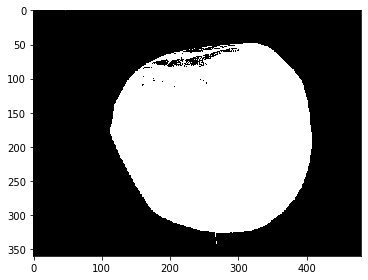

In [9]:
orange_bag_bw = orange_bag_gray<(level*1.0/255)
imshow(orange_bag_bw)

Actually, we didnt have to go through all that math since scikit image already have the the Otsu's Method as a function.

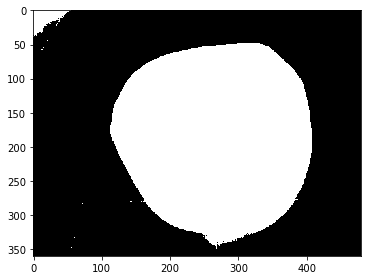

In [30]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(orange_bag_gray)
orange_bag_binary_otsu2  = orange_bag_gray < thresh
imshow(orange_bag_binary_otsu2)

So far, so good. The function does about as well as when we were working with manual thresholds earlier.  This time, we let the function choose our threshold, which makes it easier to find a middle ground across multiple images.

Now consider this image where we have more than one 'subject':

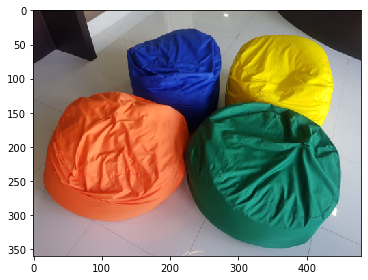

In [33]:
bags = imread('bags.png')
imshow(bags)

Let's try segmenting it using Otsu's Method directly:

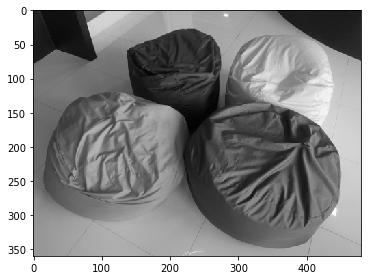

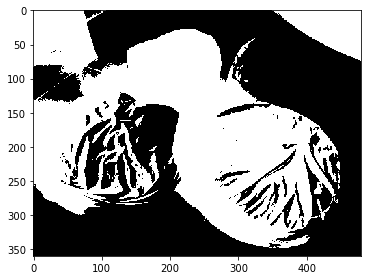

In [34]:
import matplotlib.pyplot as plt

bags_gray = rgb2gray(bags)
imshow(bags_gray)
plt.show()

thresh = threshold_otsu(bags_gray)
bags_binary_otsu2  = bags_gray < thresh
imshow(bags_binary_otsu2)
plt.show()

From the above, we have a better understanding that it isn't so simple anymore.  Not only do different subjects have varying thresholds, one of them practically disappears into the background (remember: video call backgrounds).  And this is for simple subjects with a solid colour.

This result is an illustration of a critical assumption with the Otsu's method: that the subject and background are well defined in the image.  Or more precisely, in a mathematical sense: the grayscale values of the subject are sufficiently contrasted against their background.  When that assumption falls through we run into some significant problems.

## 2. Color Image Segmentation
Since there are now multiple objects of interest, we need to look at other information to segment our image. In this case, we choose instead to segment it using the color channels.

### 2.1 RGB Color Space
#### Exercise:
Exploit our knowledge of the RGB space to segment the blue beanbag.

In our image, we conveniently have subjects that fit rather neatly into a single channel on the RGB colour space.  To illustrate, refer to the image below which show the different channels in our image.  We see that depending on the channel certain subjects are highlighted. At the same time however, when dealing with the image as a whole, we see that for each subject we have to adjust the channel thresholds individually.  More so, when the colours are not neatly red, green, or blue (e.g. orange). Not ideal.

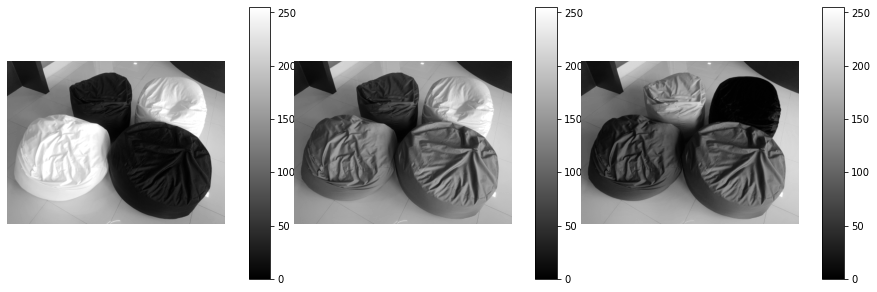

In [53]:
fig, ax = plt.subplots(1, 6, gridspec_kw=dict(width_ratios=[10,1,10,1,10,1]),
                       figsize=(15,5))

for i,j in zip(range(3), range(0,6,2)):
    img = ax[j].imshow(bags[:,:,i], cmap='gray')
    ax[j].axis('off')
    fig.colorbar(img, cax=ax[j+1]);

<ipython-input-63-8479261c1de1>:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  bags_gray = rgb2gray((bags[:,:,0]>130) & (bags[:,:,1]<95)
<ipython-input-63-8479261c1de1>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  bags_gray = rgb2gray((bags[:,:,0]<50) & (bags[:,:,1]>50)
<ipython-input-63-8479261c1de1>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D im

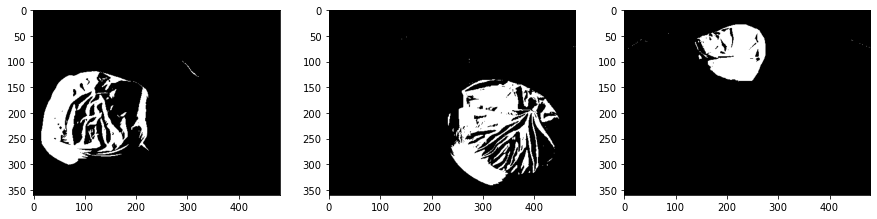

In [63]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

bags_gray = rgb2gray((bags[:,:,0]>130) & (bags[:,:,1]<95)
                     & (bags[:,:,2]<130))
ax[0].imshow(bags_gray, cmap='gray')
bags_gray = rgb2gray((bags[:,:,0]<50) & (bags[:,:,1]>50)
                     & (bags[:,:,2]<100))
ax[1].imshow(bags_gray, cmap='gray')
bags_gray = rgb2gray((bags[:,:,0]<100) & (bags[:,:,1]<100)
                     & (bags[:,:,2]>100))
ax[2].imshow(bags_gray, cmap='gray')

### 2.2 HSV Color Space

Handling color image segmentation will get a bit tricky especially when we need to consider the different shades and hues  Let's try a different colour space instead. We can instead use the HSV color-space to isolate specific parts of the image based on the color.  Using hue, it becomes easier to segment the image by colour, and uses only a single channel.  It's not exactly *clean*, but that's something morphological operations or region properties can help with easily.

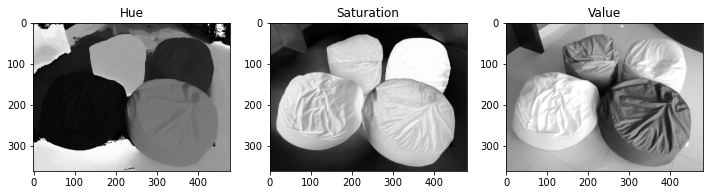

In [65]:
from skimage.color import rgb2hsv
bags_hsv = rgb2hsv(bags)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(bags_hsv[:,:,0], cmap='gray')
ax[0].set_title('Hue')
ax[1].imshow(bags_hsv[:,:,1], cmap='gray')
ax[1].set_title('Saturation')
ax[2].imshow(bags_hsv[:,:,2], cmap='gray')
ax[2].set_title('Value');

It is a bit hard to see our images using the intensity values of our HSV color space. So instead, we will use a different color map for visualization:

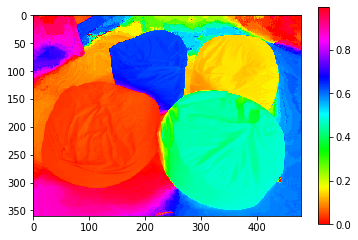

In [15]:
plt.imshow(bags_hsv[:,:,0],cmap='hsv')
plt.colorbar()

Now, try to threshold our image using the Hue part of the HSV color channel to segment our blue beanbag,

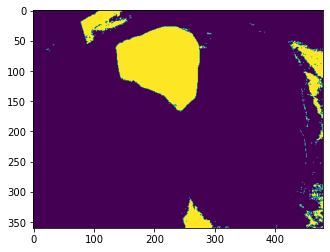

In [66]:
# blue 

lower_mask = bags_hsv[:,:,0] > 0.60
upper_mask = bags_hsv[:,:,0] < 0.68
mask = upper_mask*lower_mask
plt.imshow(mask)

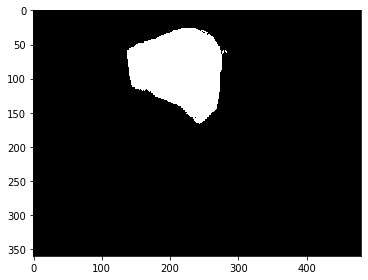

In [88]:
from skimage.measure import label, regionprops

blue_lbl = label(mask)
props = regionprops(blue_lbl)
areas = np.argmax([x.area for x in props])
# display(np.unique(blue_lbl))
imshow(blue_lbl==12)
mask_b = blue_lbl==12

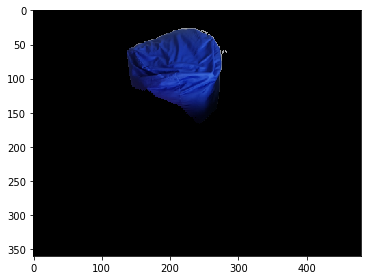

In [89]:
red = bags[:,:,0]*mask_b
green = bags[:,:,1]*mask_b
blue = bags[:,:,2]*mask_b
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)

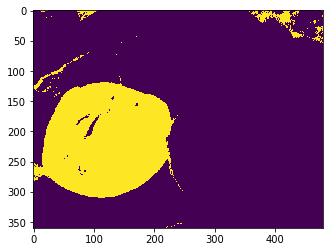

In [97]:
# orange

lower_mask = bags_hsv[:,:,0] > 0.02
upper_mask = bags_hsv[:,:,0] < 0.06
mask = upper_mask*lower_mask
plt.imshow(mask)

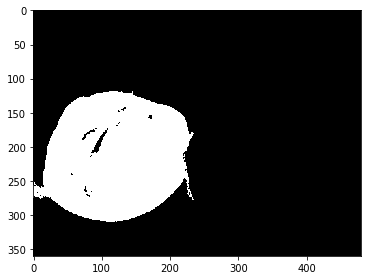

In [99]:
orange_lbl = label(mask)
props = regionprops(orange_lbl)
areas = np.argmax([x.area for x in props])
# display(np.unique(blue_lbl))
imshow(orange_lbl==(areas+1))
mask_o = orange_lbl==(areas+1)

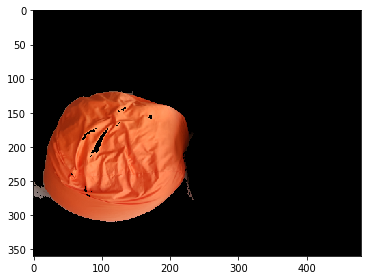

In [100]:
red = bags[:,:,0]*mask_o
green = bags[:,:,1]*mask_o
blue = bags[:,:,2]*mask_o
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)

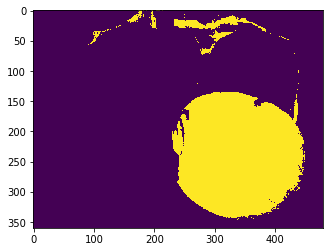

In [107]:
# green

lower_mask = bags_hsv[:,:,0] > 0.32
upper_mask = bags_hsv[:,:,0] < 0.48
mask = upper_mask*lower_mask
plt.imshow(mask)

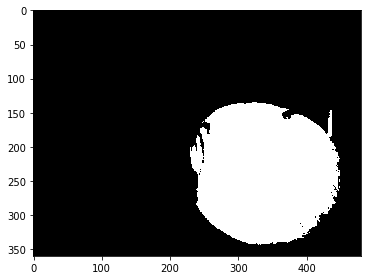

In [108]:
green_lbl = label(mask)
props = regionprops(green_lbl)
areas = np.argmax([x.area for x in props])
# display(np.uniqugreen_lbl))
imshow(green_lbl==(areas+1))
mask_g = green_lbl==(areas+1)

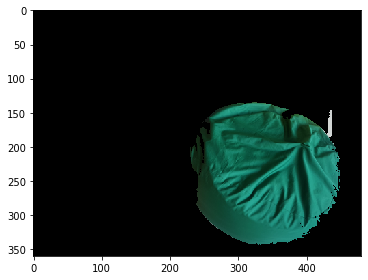

In [109]:
red = bags[:,:,0]*mask_g
green = bags[:,:,1]*mask_g
blue = bags[:,:,2]*mask_g
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)

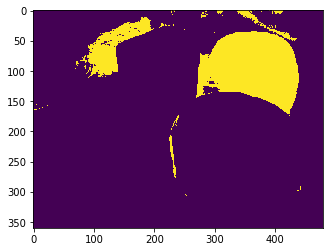

In [116]:
# yellow

lower_mask = bags_hsv[:,:,0] > 0.10
upper_mask = bags_hsv[:,:,0] < 0.2
mask = upper_mask*lower_mask
plt.imshow(mask)

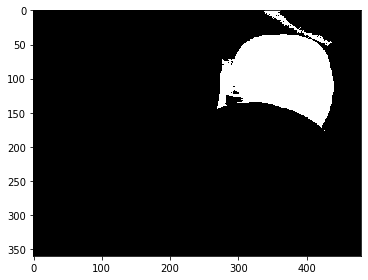

In [117]:
yellow_lbl = label(mask)
props = regionprops(yellow_lbl)
areas = np.argmax([x.area for x in props])
# display(np.unique(yellow_lbl))
imshow(yellow_lbl==(areas+1))
mask_y = yellow_lbl==(areas+1)

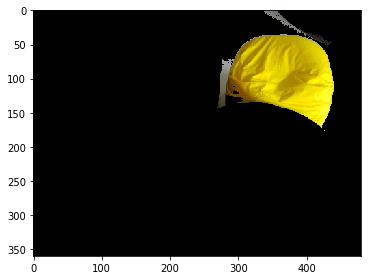

In [118]:
red = bags[:,:,0]*mask_y
green = bags[:,:,1]*mask_y
blue = bags[:,:,2]*mask_y
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)

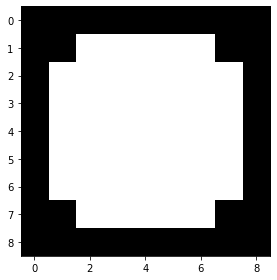

In [124]:
from skimage.draw import circle

circ_image = np.zeros((9, 9))
circ_image[circle(4, 4, 4)] = 1
imshow(circ_image);

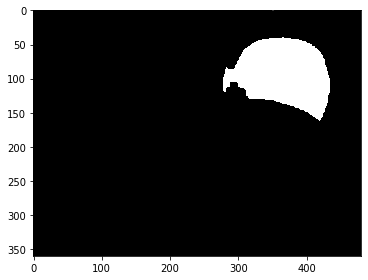

In [128]:
from skimage.morphology import erosion, dilation

imshow(dilation(erosion(mask_y, circ_image)))

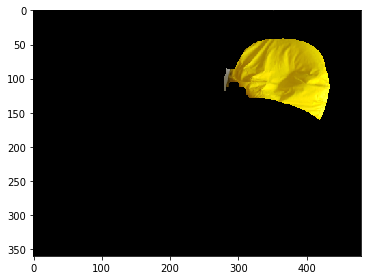

In [129]:
mask_y = erosion(mask_y, circ_image)
red = bags[:,:,0]*mask_y
green = bags[:,:,1]*mask_y
blue = bags[:,:,2]*mask_y
bags_masked = np.dstack((red,green,blue))
imshow(bags_masked)